<a href="https://colab.research.google.com/github/joaquinAmiel/BairesDev/blob/master/Data_science_assignment_RP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data science Assignment
## 1. Problem description
### Data
**Features (test dataset)**:
- customer: int id of the customer
- contract id: int id of the contract (a customer can have N contracts)
- contract_type: string representing the type of contract
- year: int
- month: int
- quarter: int
- startdate: beginning of the contract in int milliseconds since 1970 
- enddate: end of the contract in int milliseconds since 1970 
- is_active: str
- A_true: int number of cases that are in state A_true
- A_false: int number of cases that are in state A_false
- internal_B_true: int number of cases introduced by the system that are in - state B_true
- external_B_true: int number of cases introduced externally that are in state B_true
- B_true: int sum of the previous two features
- internal_C_true: int number of cases introduced by the system that are in state C_true
- external_C_true: int number of cases introduced externally that are in state C_true
- C_true: int sum of the previous two features
- <time>_B_true_C_true: float [0, 1] percentage of cases that went from B_true to C_true in the specified time frame
- <metric>_time_start_C_true: int time measured in days that took a case to reach C_true from the start with the applied grouping operation
- <metric>_time_B_true_C_true: int time measured in days that took a case to reach C_true from the B_true with the applied grouping operation
- Automatization_A: Percentage of cases that reached a A_True or A_False automatically from the start by means of a predefined external input. No manual work was involved.
- Automatization_B: Percentage of cases that reached a B_True or B_False automatically from the A_True by means of a predefined external input. No manual work was involved.
- Automatization_C: Percentage of cases that reached a C_True or C_False automatically from the B_True by means of a predefined external input. No manual work was involved.

**Conversion features: (test conversion)**
- contract id: int id of the contract 
- sf_account_id: int id of additional info associated to that contract

**Additional features (test other dataset):**
- sf_account_id: int id of additional info associated to that contract
- Company Type: string Type of customer.
- Plan Tier: category Importance of the customer plan 
- Country: str customer's country.
- Business Unit: str
- Industry: str customer's industry.
- Vertical: str customer's vertical.

### Goals
- The main goal is to predict whether a given customer will churn or not, you can find a boolean field called ACTIVE and use that as a measure of churn or not churn.
- We are also interested in extracting insights, not just a binary prediction, but also why the customer might churn.
  - A couple of examples that we would be interested to explore are time-related graphs containing the evolution in matches and infringements for customers churning or not.
  - The above point is something that we "think" could be potential issues for churning, but we are not sure they are the most important features to explore. 

## Data managment
### Import libraries and functions

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import itertools
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from google.colab import drive
# mount google drive information in a google colaboratory directory
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.tight_layout()

### Read files

In [3]:
#read data bases
path = r'gdrive/My Drive/Red Points/Data/' # path
#path = 'Data/' # path
df = pd.read_csv(path+'test_dataset.csv',sep=';',index_col=0)
df_aditional = pd.read_csv(path+'test_other_dataset.csv',index_col=0)
df_link = pd.read_csv(path+'test_conversion.csv',index_col=0)

In [4]:
print("Main features dimension: " + str(df.shape))
print("Conversion features dimension: " + str(df_link.shape))
print("Aditional features dimension: " + str(df_aditional.shape))

Main features dimension: (17034, 43)
Conversion features dimension: (1082, 2)
Aditional features dimension: (2740, 9)


### Treatment of *df* data

In [5]:
df['startdate'] = pd.to_datetime(df['startdate'],unit='ms')
df['enddate'] = pd.to_datetime(df['enddate'],unit='ms')
df.sort_values(by=['customer','contractid','year','month'], inplace=True)
df.head(5)

,customer,contractid,year,quarter,month,contract_type,startdate,enddate,is_active,A_true,A_false,internal_B_true,external_B_true,B_true,internal_C_true,external_C_true,C_true,one_week_B_true_C_true,two_weeks_B_true_C_true,one_month_B_true_C_true,BORRAR,BORRAR_2,avg_time_start_C_true,median_time_start_C_true,min_time_start_C_true,max_time_start_C_true,avg_time_B_true_C_true,median_time_B_true_C_true,BORRAR_3,avg_start_A_true,avg_start_A_false,avg_A_true_B_true,avg_A_true_B_false,BORRAR_4,BORRAR_5,BORRAR_6,BORRAR_7,avg_B_true_C_false,automatization_A,automatization_B,automatization_C,BORRAR_8,B_false
9603,0,321,2018,1,1,Brand,2018-10-24,2020-04-06,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3740,0,321,2018,1,2,Brand,2018-10-24,2020-04-06,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6605,0,321,2018,1,3,Brand,2018-10-24,2020-04-06,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1191,0,321,2018,2,4,Brand,2018-10-24,2020-04-06,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6606,0,321,2018,2,5,Brand,2018-10-24,2020-04-06,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are only two clients with more than one contract

In [6]:
pd.value_counts(df.groupby('customer').contractid.nunique())

1    496
2      2
Name: contractid, dtype: int64

This clients were analysed in order to evaluate if they need to be spotted for this particular analysis


In [7]:
prueba=df.groupby('customer').contractid.nunique()
prueba[prueba==2]

customer
67     2
718    2
Name: contractid, dtype: int64

In [8]:
pd.set_option('display.max_rows', 70)
df[df.customer==67]

,customer,contractid,year,quarter,month,contract_type,startdate,enddate,is_active,A_true,A_false,internal_B_true,external_B_true,B_true,internal_C_true,external_C_true,C_true,one_week_B_true_C_true,two_weeks_B_true_C_true,one_month_B_true_C_true,BORRAR,BORRAR_2,avg_time_start_C_true,median_time_start_C_true,min_time_start_C_true,max_time_start_C_true,avg_time_B_true_C_true,median_time_B_true_C_true,BORRAR_3,avg_start_A_true,avg_start_A_false,avg_A_true_B_true,avg_A_true_B_false,BORRAR_4,BORRAR_5,BORRAR_6,BORRAR_7,avg_B_true_C_false,automatization_A,automatization_B,automatization_C,BORRAR_8,B_false
9467,67,394,2018,1,1,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3499,67,394,2018,1,2,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6469,67,394,2018,1,3,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920,67,394,2018,2,4,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6470,67,394,2018,2,5,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13970,67,394,2018,2,6,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9843,67,394,2018,3,7,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7967,67,394,2018,3,8,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,67,394,2018,3,9,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,67,394,2018,4,10,Piracy,2018-12-31,NaT,active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df[df.customer==718]

,customer,contractid,year,quarter,month,contract_type,startdate,enddate,is_active,A_true,A_false,internal_B_true,external_B_true,B_true,internal_C_true,external_C_true,C_true,one_week_B_true_C_true,two_weeks_B_true_C_true,one_month_B_true_C_true,BORRAR,BORRAR_2,avg_time_start_C_true,median_time_start_C_true,min_time_start_C_true,max_time_start_C_true,avg_time_B_true_C_true,median_time_B_true_C_true,BORRAR_3,avg_start_A_true,avg_start_A_false,avg_A_true_B_true,avg_A_true_B_false,BORRAR_4,BORRAR_5,BORRAR_6,BORRAR_7,avg_B_true_C_false,automatization_A,automatization_B,automatization_C,BORRAR_8,B_false
22825,718,506,2018,1,1,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21971,718,506,2018,1,2,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25676,718,506,2018,1,3,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18628,718,506,2018,2,4,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25677,718,506,2018,2,5,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20907,718,506,2018,2,6,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2261,718,506,2018,3,7,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4435,718,506,2018,3,8,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25482,718,506,2018,3,9,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22826,718,506,2018,4,10,Brand,2019-03-26,2020-10-05,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


At the end, it's the same working with clients and with contracts since the relationship within them is 1 to 1. 

In [10]:
# 507 contract id was deleted because it doesn't contain any information
df=df[df.contractid!=507]
# customer 67 was deleted in order to simplify the model
df=df[df.customer!=67]



All contract in the database started after january 2018.

In [11]:
df.startdate.min()

Timestamp('2018-01-09 00:00:00')

This columns were dropped because it doesn't specify in the data descripcion what is the meaning of this ones. 

In [12]:
df.drop(columns=['BORRAR','BORRAR_2','BORRAR_3','BORRAR_4','BORRAR_5','BORRAR_6','BORRAR_7','BORRAR_8'], inplace=True)

This variables are just the month of the operation, at the end a sumarization is going to do by customer, so this variables were dropped

In [13]:
df.drop(columns=['year','quarter','month'], inplace=True)

As we can see, the sample does not have balancing problems, that is, all the categories are well represented. therefore, the accuracy measure can be used to evaluate the models

In [14]:
print('Contract distribution:')
round(100*pd.value_counts(df['is_active'])/df.shape[0],2)

Contract distribution:


inactive    60.84
active      39.16
Name: is_active, dtype: float64

There is no clients with more than one status

In [15]:
df.groupby('customer').is_active.nunique().max()

1

In [16]:
#if the client churn, then 0, else 1, because the customer is not active.
df['is_active']=np.where(df.is_active=='active',0,1)

### Treatment of df_aditional data

In [17]:
df_aditional.head(10)

,Company Type,Plan Tier,Country,Business Unit,Industry,Vertical,Contract Start Date,Contract End Date,sf_account_id
0,SMB,Tier 3,UNITED STATES,1,Fashion,Clothing,2018-10-22,2020-04-01,440
1,SMB,NaN,UNITED STATES,2,E-Learning,Content Creator,2020-01-08,2020-04-07,1384
2,SMB,Tier 3,UNITED STATES,1,Fashion,Clothing,2018-10-22,2019-11-01,454
3,SMB,Tier 3,GERMANY,1,Sports & Outdoor,General Sports,2019-03-19,2020-04-20,1052
4,SMB,Tier 3,UNITED STATES,1,Fashion,Accessories,2019-12-13,2020-06-13,1294
5,Editor,Tier 3,EGYPT,3,NaN,NaN,2020-02-19,NaN,602
6,Editor,Tier 3,EGYPT,3,NaN,NaN,2018-09-05,2019-04-26,602
7,Editor,Tier 3,EGYPT,3,NaN,NaN,2020-03-04,NaN,602
8,Editor,Tier 3,EGYPT,3,NaN,NaN,2019-02-11,2019-02-22,602
9,Editor,Tier 3,EGYPT,3,NaN,NaN,2019-05-02,2019-05-11,602


In [18]:
df_aditional.rename(columns={'Company Type':'company_type',
                             'Plan Tier':'plan_tier',
                             'Business Unit':'business_unit',
                             'Contract Start Date':'contract_start_date',
                             'Contract End Date':'contract_end_date'}, inplace=True)

In [19]:
#import datetime as dt
df_aditional['contract_end_date']=pd.to_datetime(df_aditional.contract_end_date, format='%Y-%m-%d')
df_aditional['contract_start_date']=pd.to_datetime(df_aditional.contract_start_date, format='%Y-%m-%d')

In [20]:
df_aditional.columns

Index(['company_type', 'plan_tier', 'Country', 'business_unit', 'Industry',
       'Vertical', 'contract_start_date', 'contract_end_date',
       'sf_account_id'],
      dtype='object')

In [21]:
df_aditional.sort_values(by=['sf_account_id','contract_start_date'], inplace=True)
start=df_aditional.groupby(['sf_account_id','company_type', 'plan_tier', 'Country',
                      'business_unit', 'Industry','Vertical'])['contract_start_date'].min().reset_index()

end=df_aditional.groupby(['sf_account_id','company_type', 'plan_tier', 'Country',
                      'business_unit', 'Industry','Vertical' ])['contract_end_date'].max().reset_index()

df_aditional_depurated=pd.merge(start, end,  how='inner', on=['sf_account_id','company_type', 'plan_tier', 
                                                                    'Country','business_unit', 'Industry','Vertical'])

## Treatment of *df_link* data

In [22]:
df_link.head()
df_link.drop_duplicates(keep='last', inplace = True) 
df_link=df_link[-df_link.sf_account_id.isnull()]

df_aditional_depurated=pd.merge(df_aditional_depurated, df_link,  how='inner', on='sf_account_id')

In [23]:
df_clients_with_ad=pd.merge(df[['contractid','customer']], df_aditional_depurated,  how='left', on='contractid')
df_clients_with_ad=df_clients_with_ad[-df_clients_with_ad.sf_account_id.isnull()]
df_clients_with_ad.drop_duplicates(keep='last', inplace = True) 

Its is decided not use aditional data because only 10% of the customers have this kind of data. Also, this data is not good for get insight because it is not statisticaly significant (the database have only 50 clients with aditional data).

In [24]:
#df2=pd.merge(df, df_clients_with_ad, how='left', on='contractid')
round(100*df_clients_with_ad.customer.nunique()/df.customer.nunique(),2)

9.66

## Data cleansing
### Categorical's variables treatment

In [25]:
descriptive_table = df.describe(include='all').round(decimals=3)
description_object=descriptive_table.loc[['count','unique','top','freq']] 
description_object.dropna(axis=1, thresh=None, inplace=True)
description_object

,contract_type,startdate,enddate
count,16796,16932,10268
unique,2,178,163
top,Brand,2018-12-31 00:00:00,2020-07-22 00:00:00
freq,15334,612,544


In [26]:
pd.value_counts(df.contract_type)

Brand     15334
Piracy     1462
Name: contract_type, dtype: int64

There are contracts with more than one status. For this reason dummy variables were created.

In [27]:
df.groupby('contractid').contract_type.nunique().max()

2

In [28]:
df['is_brand']=np.where(df.contract_type=='Brand',1,0)
df['is_piracy']=np.where(df.contract_type=='Piracy',1,0)
df.drop(columns=['contract_type'],inplace=True)

Antiqueness variable was created in order to get average measures for the customers.

In [29]:
df.enddate.fillna(datetime.datetime(2020,11,1),inplace=True)
df['ant_months']= ((df.enddate - df.startdate)/np.timedelta64(1, 'M'))
df['ant_months'] = df['ant_months'].astype(int)
df.drop(columns=['enddate','startdate'],inplace=True)

In [30]:
df.ant_months.describe()

count    16932.000000
mean        17.226908
std          9.809653
min          0.000000
25%          8.000000
50%         18.000000
75%         25.000000
max         42.000000
Name: ant_months, dtype: float64

Data with antiqueness equal zero was dropped because it doesn't contain any data inside just nulls and zeros.

In [31]:
df=df[df.ant_months!=0]

## Numerical's variables treatment

In [32]:
df.describe()

,customer,contractid,is_active,A_true,A_false,internal_B_true,external_B_true,B_true,internal_C_true,external_C_true,C_true,one_week_B_true_C_true,two_weeks_B_true_C_true,one_month_B_true_C_true,avg_time_start_C_true,median_time_start_C_true,min_time_start_C_true,max_time_start_C_true,avg_time_B_true_C_true,median_time_B_true_C_true,avg_start_A_true,avg_start_A_false,avg_A_true_B_true,avg_A_true_B_false,avg_B_true_C_false,automatization_A,automatization_B,automatization_C,B_false,is_brand,is_piracy,ant_months
count,16762.000000,16762.000000,16762.000000,8219.000000,5797.000000,6376.000000,1383.000000,6446.000000,8081.000000,1527.000000,8099.000000,7425.000000,7425.000000,7425.000000,7477.000000,7477.000000,7477.000000,7477.000000,7425.000000,7425.000000,7178.000000,7101.000000,7242.000000,6305.000000,3859.000000,7283.000000,7408.000000,6697.000000,6622.000000,16762.000000,16762.000000,16762.000000
mean,513.553753,273.111562,0.604462,1291.173622,1394.326893,718.971612,34.127260,718.486038,471.642990,22.507531,474.838375,3.454848,4.865452,6.628876,120.142437,111.184700,64.005350,259.542597,99.905859,90.375084,19.183617,8.079285,7.724109,9.525773,42.349313,0.309213,0.157441,0.146878,400.715192,0.908722,0.085193,17.401623
std,291.067831,147.681654,0.488980,4735.705045,5226.195570,3925.900164,142.710873,3906.881244,2991.796635,70.784814,2989.612179,42.945775,54.263943,67.790801,132.259909,138.359154,123.924374,196.278790,127.179986,132.118081,54.336937,28.463845,21.098223,23.590837,76.012303,0.383261,0.292057,0.295121,2012.893012,0.288012,0.279177,9.703855
min,0.000000,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,276.000000,147.000000,0.000000,93.000000,13.000000,38.000000,2.000000,38.000000,14.000000,1.000000,14.000000,0.000000,0.000000,0.000000,31.000000,22.000000,2.000000,95.000000,18.000000,11.000000,1.000000,0.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,12.000000,1.000000,0.000000,9.000000
50%,513.000000,270.000000,1.000000,335.000000,91.000000,141.000000,6.000000,142.000000,70.000000,4.000000,71.000000,0.040404,0.200000,0.500000,71.000000,53.000000,10.000000,216.000000,50.000000,32.000000,3.000000,2.000000,2.000000,3.000000,13.000000,0.070000,0.000000,0.000000,52.000000,1.000000,0.000000,18.000000
75%,777.000000,400.000000,1.000000,941.500000,618.000000,438.000000,24.000000,439.000000,256.000000,15.000000,262.000000,0.368421,0.643836,0.888889,156.000000,142.000000,54.000000,385.000000,124.000000,107.000000,11.000000,5.000000,6.000000,8.000000,44.000000,0.650000,0.150000,0.090000,203.000000,1.000000,0.000000,25.000000
max,1014.000000,531.000000,1.000000,159745.000000,157761.000000,138697.000000,3371.000000,138697.000000,121979.000000,1061.000000,121979.000000,992.000000,992.000000,992.000000,887.000000,911.000000,875.000000,937.000000,815.000000,836.000000,749.000000,479.000000,405.000000,413.000000,642.000000,1.000000,1.000000,1.000000,70950.000000,1.000000,1.000000,42.000000


Some NAs were replaced by zero, because are counting cases, max or min

In [33]:
df.A_true.fillna(0,inplace=True)
df.A_false.fillna(0,inplace=True) 
df.internal_B_true.fillna(0,inplace=True) 
df.external_B_true.fillna(0,inplace=True) 
df.B_true.fillna(0,inplace=True) 
df.internal_C_true.fillna(0,inplace=True) 
df.external_C_true.fillna(0,inplace=True) 
df.C_true.fillna(0,inplace=True) 
df.one_week_B_true_C_true.fillna(0,inplace=True) 
df.two_weeks_B_true_C_true.fillna(0,inplace=True) 
df.one_month_B_true_C_true.fillna(0,inplace=True) 
df.one_month_B_true_C_true.fillna(0,inplace=True) 
df.automatization_A.fillna(0,inplace=True) 
df.automatization_B.fillna(0,inplace=True) 
df.automatization_C.fillna(0,inplace=True) 
df.max_time_start_C_true.fillna(0,inplace=True) 
df.min_time_start_C_true.fillna(0,inplace=True) 


### Database's construction

In [34]:
df_contract_sum=df.groupby(['contractid'])['A_true','A_false', 'internal_B_true', 'external_B_true', 'B_true', 'B_false',
                                         'internal_C_true', 'external_C_true', 'C_true','one_week_B_true_C_true', 'two_weeks_B_true_C_true',
                                         'one_month_B_true_C_true', 'automatization_A', 'automatization_B', 'automatization_C',
                                         'avg_time_start_C_true','avg_time_B_true_C_true','avg_A_true_B_true','avg_A_true_B_false',
                                         'avg_B_true_C_false'].sum().reset_index()

In [35]:
df_contract_max=df.groupby(['contractid'])['customer','max_time_start_C_true', 'is_brand','is_piracy','is_active', 'ant_months'].max().reset_index()
df_contract_min=df.groupby(['contractid'])['min_time_start_C_true'].min().reset_index()

In [36]:
df_contract=pd.merge(df_contract_sum,df_contract_min,on='contractid',how='inner')
df_contract=pd.merge(df_contract,df_contract_max,on='contractid',how='inner')

In [37]:
df_contract['A_true_per_month'] = df_contract['A_true']/df_contract['ant_months']
df_contract['A_false_per_month'] = df_contract['A_false']/df_contract['ant_months']
df_contract['internal_B_true_per_month'] = df_contract['internal_B_true']/df_contract['ant_months']
df_contract['external_B_true_per_month'] = df_contract['external_B_true']/df_contract['ant_months']
df_contract['B_true_per_month'] = df_contract['B_true']/df_contract['ant_months']
df_contract['B_false_per_month'] = df_contract['B_false']/df_contract['ant_months']
df_contract['internal_C_true_per_month'] = df_contract['internal_C_true']/df_contract['ant_months']
df_contract['external_C_true_per_month'] = df_contract['external_C_true']/df_contract['ant_months']
df_contract['C_true_per_month'] = df_contract['C_true']/df_contract['ant_months']
df_contract['one_week_B_true_C_true_per_month'] = df_contract['one_week_B_true_C_true']/df_contract['ant_months']
df_contract['two_weeks_B_true_C_true_per_month'] = df_contract['two_weeks_B_true_C_true']/df_contract['ant_months']
df_contract['one_month_B_true_C_true_per_month'] = df_contract['one_month_B_true_C_true']/df_contract['ant_months']
df_contract['automatization_A_per_month'] = df_contract['automatization_A']/df_contract['ant_months']
df_contract['automatization_B_per_month'] = df_contract['automatization_B']/df_contract['ant_months']
df_contract['automatization_C_per_month'] = df_contract['automatization_C']/df_contract['ant_months']
df_contract['avg_time_start_C_true_per_month'] = df_contract['avg_time_start_C_true']/df_contract['ant_months']
df_contract['avg_time_B_true_C_true_per_month'] = df_contract['avg_time_B_true_C_true']/df_contract['ant_months']
df_contract['avg_A_true_B_true_per_month'] = df_contract['avg_A_true_B_true']/df_contract['ant_months']
df_contract['avg_A_true_B_false_per_month'] = df_contract['avg_A_true_B_false']/df_contract['ant_months']
df_contract['avg_B_true_C_false_per_month'] = df_contract['avg_B_true_C_false']/df_contract['ant_months']

In [38]:
df_contract.describe()

,contractid,A_true,A_false,internal_B_true,external_B_true,B_true,B_false,internal_C_true,external_C_true,C_true,one_week_B_true_C_true,two_weeks_B_true_C_true,one_month_B_true_C_true,automatization_A,automatization_B,automatization_C,avg_time_start_C_true,avg_time_B_true_C_true,avg_A_true_B_true,avg_A_true_B_false,avg_B_true_C_false,min_time_start_C_true,customer,max_time_start_C_true,is_brand,is_piracy,is_active,ant_months,A_true_per_month,A_false_per_month,internal_B_true_per_month,external_B_true_per_month,B_true_per_month,B_false_per_month,internal_C_true_per_month,external_C_true_per_month,C_true_per_month,one_week_B_true_C_true_per_month,two_weeks_B_true_C_true_per_month,one_month_B_true_C_true_per_month,automatization_A_per_month,automatization_B_per_month,automatization_C_per_month,avg_time_start_C_true_per_month,avg_time_B_true_C_true_per_month,avg_A_true_B_true_per_month,avg_A_true_B_false_per_month,avg_B_true_C_false_per_month
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,273.302846,21569.422764,16428.684959,9317.404472,95.930894,9413.335366,5393.365854,7746.640244,69.855691,7816.495935,52.138719,73.426791,100.039445,4.577236,2.370569,1.999268,1825.823171,1507.725610,113.695122,122.073171,332.166667,0.0,514.036585,475.764228,0.910569,0.085366,0.605691,17.376016,1077.731656,768.907866,459.421719,4.072758,463.494476,245.140699,387.436838,2.970218,390.407056,3.288058,5.509388,8.139816,0.265278,0.122755,0.114444,157.653655,139.370424,6.470161,6.772734,19.265429
std,147.916624,69892.371511,47855.622695,49923.578127,390.322869,49968.154898,24125.797292,43463.882163,309.538829,43493.594053,176.976430,226.266912,259.298789,4.784185,3.923227,4.138439,1460.895653,1247.427866,221.201681,203.631558,399.846550,0.0,291.453829,234.423680,0.285655,0.279710,0.489199,9.706638,3005.569886,1941.941347,2398.664431,16.069068,2399.555614,836.330813,2097.424080,12.836860,2097.993046,15.562079,28.746746,33.994912,0.508295,0.240099,0.276324,288.341679,290.043782,11.505110,10.714818,30.849593
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,146.750000,1158.750000,30.250000,304.000000,0.000000,304.000000,62.000000,223.500000,0.000000,223.500000,0.980258,1.899273,2.889645,0.037500,0.000000,0.000000,794.250000,640.750000,18.000000,12.000000,18.750000,0.0,274.500000,341.250000,1.000000,0.000000,0.000000,9.000000,127.735197,3.900568,27.416667,0.000000,27.445312,7.500000,19.760256,0.000000,20.100000,0.069419,0.152817,0.252133,0.005889,0.000000,0.000000,51.266667,40.456140,1.945833,1.333333,2.776786
50%,270.500000,4699.000000,1206.500000,1298.000000,0.000000,1370.000000,611.000000,1123.000000,0.000000,1173.500000,2.383621,4.184125,6.424145,3.045000,0.045000,0.000000,1587.500000,1286.500000,56.000000,54.000000,204.000000,0.0,514.000000,492.500000,1.000000,0.000000,1.000000,18.000000,404.083333,89.604167,105.184874,0.000000,108.055556,47.581797,83.040323,0.000000,87.612573,0.181903,0.311775,0.488781,0.201853,0.002009,0.000000,96.322581,73.180124,3.703297,3.790625,12.841230
75%,400.250000,17142.750000,9090.250000,5259.000000,22.000000,5370.750000,3587.500000,4328.750000,14.000000,4408.000000,5

In [39]:
#this variable was deleted because is always 0
df_contract.drop(columns=['min_time_start_C_true'], inplace=True)

# 3. Descriptive analysis

In [40]:
df_contract.columns

Index(['contractid', 'A_true', 'A_false', 'internal_B_true', 'external_B_true',
       'B_true', 'B_false', 'internal_C_true', 'external_C_true', 'C_true',
       'one_week_B_true_C_true', 'two_weeks_B_true_C_true',
       'one_month_B_true_C_true', 'automatization_A', 'automatization_B',
       'automatization_C', 'avg_time_start_C_true', 'avg_time_B_true_C_true',
       'avg_A_true_B_true', 'avg_A_true_B_false', 'avg_B_true_C_false',
       'customer', 'max_time_start_C_true', 'is_brand', 'is_piracy',
       'is_active', 'ant_months', 'A_true_per_month', 'A_false_per_month',
       'internal_B_true_per_month', 'external_B_true_per_month',
       'B_true_per_month', 'B_false_per_month', 'internal_C_true_per_month',
       'external_C_true_per_month', 'C_true_per_month',
       'one_week_B_true_C_true_per_month', 'two_weeks_B_true_C_true_per_month',
       'one_month_B_true_C_true_per_month', 'automatization_A_per_month',
       'automatization_B_per_month', 'automatization_C_per_month

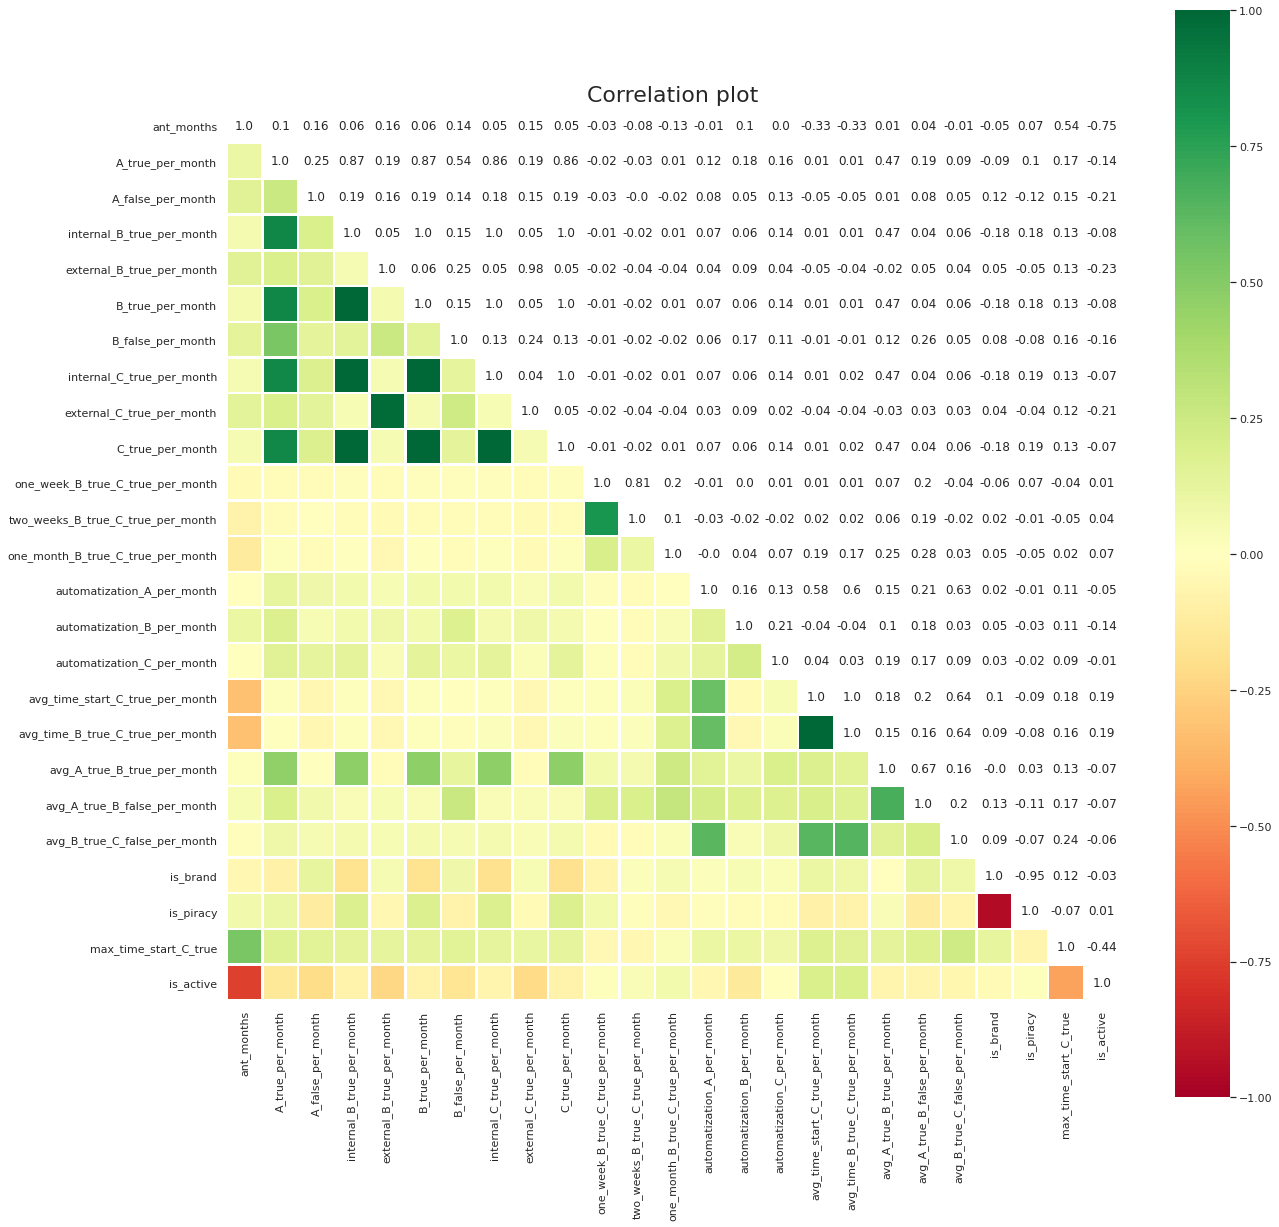

In [41]:
X_corr=df_contract[['ant_months', 'A_true_per_month', 'A_false_per_month', 'internal_B_true_per_month',
       'external_B_true_per_month', 'B_true_per_month', 'B_false_per_month',
       'internal_C_true_per_month', 'external_C_true_per_month',
       'C_true_per_month', 'one_week_B_true_C_true_per_month',
       'two_weeks_B_true_C_true_per_month',
       'one_month_B_true_C_true_per_month', 'automatization_A_per_month',
       'automatization_B_per_month', 'automatization_C_per_month',
       'avg_time_start_C_true_per_month', 'avg_time_B_true_C_true_per_month',
       'avg_A_true_B_true_per_month', 'avg_A_true_B_false_per_month','avg_B_true_C_false_per_month', 
       'is_brand', 'is_piracy','max_time_start_C_true','is_active']]
sns.set(style="white")
fig, ax = plt.subplots(1, figsize=(20, 20))
corr = X_corr.corr()
labels = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
labels = labels.round(2)
labels = labels.replace(np.nan, ' ', regex=True)

mask = np.triu(np.ones(corr.shape)).astype(np.bool)
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='RdYlGn',
    fmt='',
    square=True,
    linewidths=1.5).set_title("Correlation plot", fontsize=22)
mask = np.ones(corr.shape) - mask
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=ListedColormap(['white']),
    annot=labels,
    cbar=False,
    fmt='',
    linewidths=1.5)

The following variables were deleted for high correlation with other ones:
- avg_time_B_true_C_true_per_month
- two_weeks_B_true_C_true_per_month
- internal_B_true_per_month
- internal_C_true_per_month
- A_true_per_month
- B_true_per_month
- external_C_true_per_month
- is_brand

Ant_months variable were spotted because the model could conclude that if the customer have more than 48 months is active, but this is a consequence not a cause of the activitiness.

In [42]:
X=df_contract[['A_false_per_month', 'external_B_true_per_month', 'B_false_per_month',
       'C_true_per_month', 'one_week_B_true_C_true_per_month',
       'one_month_B_true_C_true_per_month', 'automatization_A_per_month',
       'automatization_B_per_month', 'automatization_C_per_month','avg_time_start_C_true_per_month', 
       'avg_A_true_B_true_per_month', 'avg_A_true_B_false_per_month','avg_B_true_C_false_per_month', 
       'is_piracy','max_time_start_C_true']]
y=df_contract['is_active']

The data was divided into two mutually exclusive subsets:

- Train: This subset is use to train the model.
- Test: This subset is use to verify that the model reproduce the desired results.

In [43]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0,test_size =0.2)

## data standarization

Standardizing data means adjusting the values measured at different scales to a common scale so that they can be compared. Since many statistical models work with distances, if we use data measured at different scales, this will make the scale influence the final model.

In [44]:
#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

## **Baseline**
A fundamental aspect of a model assessment is to compare with a baseline. In this case we will take as a baseline the error derived from estimating all the contracts (clients) as were inactive (majority class).

In [45]:
base=ytrain.mean()
base_predict_array =  [1] * ytest.shape[0]
base_proba_array =  [base] * ytest.shape[0]

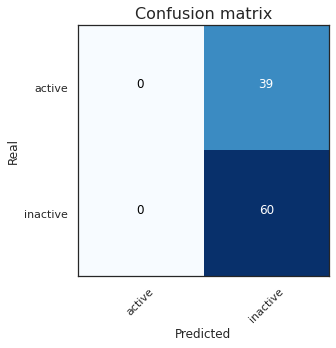

In [46]:
cnf_matrix = metrics.confusion_matrix(ytest, base_predict_array)
np.set_printoptions(precision=2)

# Gráfico
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['active','inactive'])

In [47]:
tn, fp, fn, tp = cnf_matrix.ravel()
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", round(acc_,3))
# Precision : 
pre_ = (tp) / (tp + fp)
print("Precision  : ", round(pre_,3))
# Recall : 
sens_ = tp / (tp + fn)
print("Recall  : ", round(sens_,3))
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", round(sp_,3))
print("F1_score: ", round(metrics.f1_score(ytest, base_predict_array),3))
print("AUC_score: ", round(metrics.roc_auc_score(ytest, base_predict_array),3))
print("Log Loss: ",round(metrics.log_loss(ytest,base_proba_array),3))

Accuracy  :  0.606
Precision  :  0.606
Recall  :  1.0
Specificity  :  0.0
F1_score:  0.755
AUC_score:  0.5
Log Loss:  0.67


## Logistic regression

In [48]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid_lr = GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
                    param_grid=param_grid,
                    scoring='balanced_accuracy',
                    cv = 3, verbose=2, n_jobs = -1) 

#Fit the model
grid_lr = grid_lr.fit(Xtrain, ytrain)

#predict
ypred = grid_lr.predict(Xtest)

yproba = grid_lr.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    3.4s finished


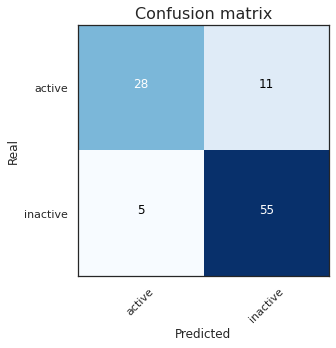

In [49]:
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# Gráfico
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['active','inactive'])

In [50]:
tn, fp, fn, tp = cnf_matrix.ravel()
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", round(acc_,3))
# Precision : 
pre_ = (tp) / (tp + fp)
print("Precision  : ", round(pre_,3))
# Recall : 
sens_ = tp / (tp + fn)
print("Recall  : ", round(sens_,3))
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", round(sp_,3))
print("F1_score: ", round(metrics.f1_score(ytest, ypred),3))
print("AUC_score: ", round(metrics.roc_auc_score(ytest, ypred),3))
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))

Accuracy  :  0.838
Precision  :  0.833
Recall  :  0.917
Specificity  :  0.718
F1_score:  0.873
AUC_score:  0.817
Log Loss:  0.418


## Classification tree

In [51]:
#List Hyperparameters that we want to tune.
criterion = ['gini','entropy']
max_depth = list(range(1,15))
min_samples_leaf=list(range(1,15))

#Convert to dictionary
hyperparameters = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf,class_weight=class_weight)

In [52]:
#from sklearn.model_selection import GridSearchCV
#Create new KNN object
model_tree2 = DecisionTreeClassifier()
#Use GridSearch
clf = GridSearchCV(model_tree2, hyperparameters, 
                   scoring='roc_auc', 
                   cv=5)

#Fit the model
tree_best_model = clf.fit(Xtrain,ytrain)

print(tree_best_model.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'class_weight': {1: 0.7, 0: 0.3}, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 11, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


In [53]:
# instanciar modelos
model_tree = DecisionTreeClassifier(criterion=tree_best_model.best_estimator_.get_params()['criterion'], 
                                    class_weight= tree_best_model.best_estimator_.get_params()['class_weight'],
                                    max_depth = tree_best_model.best_estimator_.get_params()['max_depth'],
                                    min_samples_leaf=tree_best_model.best_estimator_.get_params()['min_samples_leaf'],
                                    random_state=20)

#ajuste
model_tree.fit(Xtrain, ytrain)

#predicción
ypred = model_tree.predict(Xtest)

yproba = model_tree.predict_proba(Xtest)[:,1]

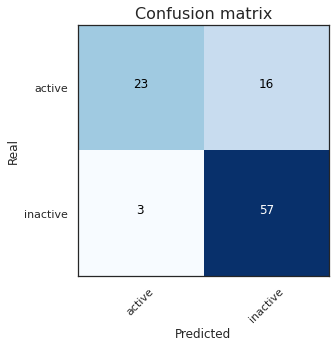

In [54]:
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# Gráfico
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['active','inactive'])

In [55]:
tn, fp, fn, tp = cnf_matrix.ravel()
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", round(acc_,3))
# Precision : 
pre_ = (tp) / (tp + fp)
print("Precision  : ", round(pre_,3))
# Recall : 
sens_ = tp / (tp + fn)
print("Recall  : ", round(sens_,3))
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", round(sp_,3))
print("F1_score: ", round(metrics.f1_score(ytest, ypred),3))
print("AUC_score: ", round(metrics.roc_auc_score(ytest, ypred),3))
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))

Accuracy  :  0.808
Precision  :  0.781
Recall  :  0.95
Specificity  :  0.59
F1_score:  0.857
AUC_score:  0.77
Log Loss:  1.463


## Random Forrest


In [64]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}

In [65]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(Xtrain, ytrain)

ypred = rf_random.predict(Xtest)

yproba = rf_random.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.0min finished


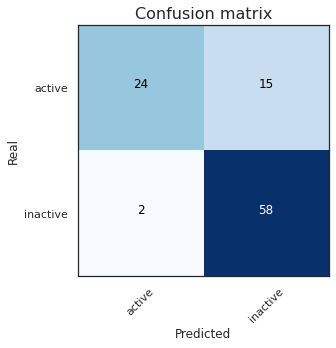

In [66]:
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# Gráfico
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['active','inactive'])

In [67]:
tn, fp, fn, tp = cnf_matrix.ravel()
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", round(acc_,3))
# Precision : 
pre_ = (tp) / (tp + fp)
print("Precision  : ", round(pre_,3))
# Recall : 
sens_ = tp / (tp + fn)
print("Recall  : ", round(sens_,3))
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", round(sp_,3))
print("F1_score: ", round(metrics.f1_score(ytest, ypred),3))
print("AUC_score: ", round(metrics.roc_auc_score(ytest, ypred),3))
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))

Accuracy  :  0.828
Precision  :  0.795
Recall  :  0.967
Specificity  :  0.615
F1_score:  0.872
AUC_score:  0.791
Log Loss:  0.39


## XGBoost

In [60]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(n_jobs=-1)
import scipy.stats as st

one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

params = {  
    "n_estimators": st.randint(50,900), # Number of boosted trees to fit.
    "max_depth": st.randint(3, 12),     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
    'class_weight':class_weight
}
xgb_cv = RandomizedSearchCV(model_xgb, params, n_iter=2000, verbose=True, cv=3)
xgb_cv.fit(Xtrain, ytrain)
ypred = xgb_cv.predict(Xtest)

yproba = xgb_cv.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6000 out of 6000 | elapsed: 11.8min finished


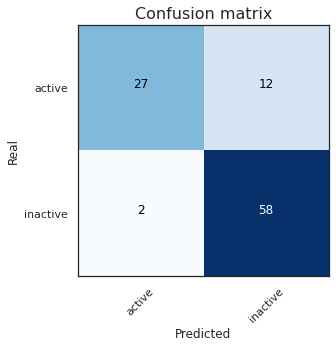

In [61]:
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# Gráfico
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['active','inactive'])

In [63]:
tn, fp, fn, tp = cnf_matrix.ravel()
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", round(acc_,3))
# Precision : 
pre_ = (tp) / (tp + fp)
print("Precision  : ", round(pre_,3))
# Recall : 
sens_ = tp / (tp + fn)
print("Recall  : ", round(sens_,3))
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", round(sp_,3))
print("F1_score: ", round(metrics.f1_score(ytest, ypred),3))
print("AUC_score: ", round(metrics.roc_auc_score(ytest, ypred),3))
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))

Accuracy  :  0.859
Precision  :  0.829
Recall  :  0.967
Specificity  :  0.692
F1_score:  0.892
AUC_score:  0.829
Log Loss:  0.372


## Final Selection models
For compare performance metric in each model, the following table was built:

| **Metric** | **Baseline** |**Logistic** | **Tree** | **Random Forrest** | **XgBoost** |
|--|--|--|--|--|--|
| **Accuracy** | 0.606 | 0.838 | 0.808 | 0.828 | **0.859** |			
| **Precision** | 0.606 | **0.833** | 0.781 | 0.795 | 0.829  |			
| **Recall** | **1** | 0.917 | 0.857 | 0.967 | 0.967  |			
| **F1 score** | 0.755 | 0.873 | 0.857 | 0.872 | **0.892**  |	
| **AUC**      | 0.500 | 0.817 |	0.770 |	0.791 |	**0.967** |
| **Log loss** | 0.670 | 0.418 | 1.463 | 0.390 | **0.372**

Comparing the results among different techniques, XGboost gives the best results in terms of accuracy, F1 score, AUC and log loss. However, the algorithm tends to predict as inactive, but is not so bad because the company can lead actions in a conservative way.

Comparing with the baseline, instead of having a 60.6% accuracy, we will have a 85.9%, which represents an increase of 41.8%.

In [94]:
headers = ['A_false_per_month', 'external_B_true_per_month', 'B_false_per_month',
          'C_true_per_month', 'one_week_B_true_C_true_per_month',
          'one_month_B_true_C_true_per_month', 'automatization_A_per_month',
          'automatization_B_per_month', 'automatization_C_per_month','avg_time_start_C_true_per_month', 
          'avg_A_true_B_true_per_month', 'avg_A_true_B_false_per_month','avg_B_true_C_false_per_month', 
          'is_piracy','max_time_start_C_true']

var_imp = pd.DataFrame({
      'feature':headers, 
      'v_importance':xgb_cv.best_estimator_.feature_importances_.tolist()})

plot_data = var_imp.sort_values(by = 'v_importance', ascending = False)    

In the following table it can be seen that the following variables have no incidence in the XGBoost model:
- A_false_per_month: number of cases per month that are in state A_false
- one_week_B_true_C_true_per_month: float [0, 1] percentage of cases that went from B_true to C_true in one week.
- one_month_B_true_C_true_per_month: float [0, 1] percentage of cases that went from B_true to C_true in one month
- automatization_C_per_month: Percentage of cases that reached a C_True or C_False automatically from the B_True by means of a predefined external input. No manual work was involved.	
- avg_A_true_B_true_per_month:
- avg_A_true_B_false_per_month:
-	is_piracy: dummy variable which indicated is the contract is piracy.

So, this variables could be spotted and redone the model.

In [93]:
plot_data

,feature,v_importance
7,automatization_B_per_month,0.228166
14,max_time_start_C_true,0.162289
1,external_B_true_per_month,0.149816
6,automatization_A_per_month,0.135267
9,avg_time_start_C_true_per_month,0.094497
12,avg_B_true_C_false_per_month,0.088684
2,B_false_per_month,0.080879
3,C_true_per_month,0.060402
0,A_false_per_month,0.000000
4,one_week_B_true_C_true_per_month,0.000000


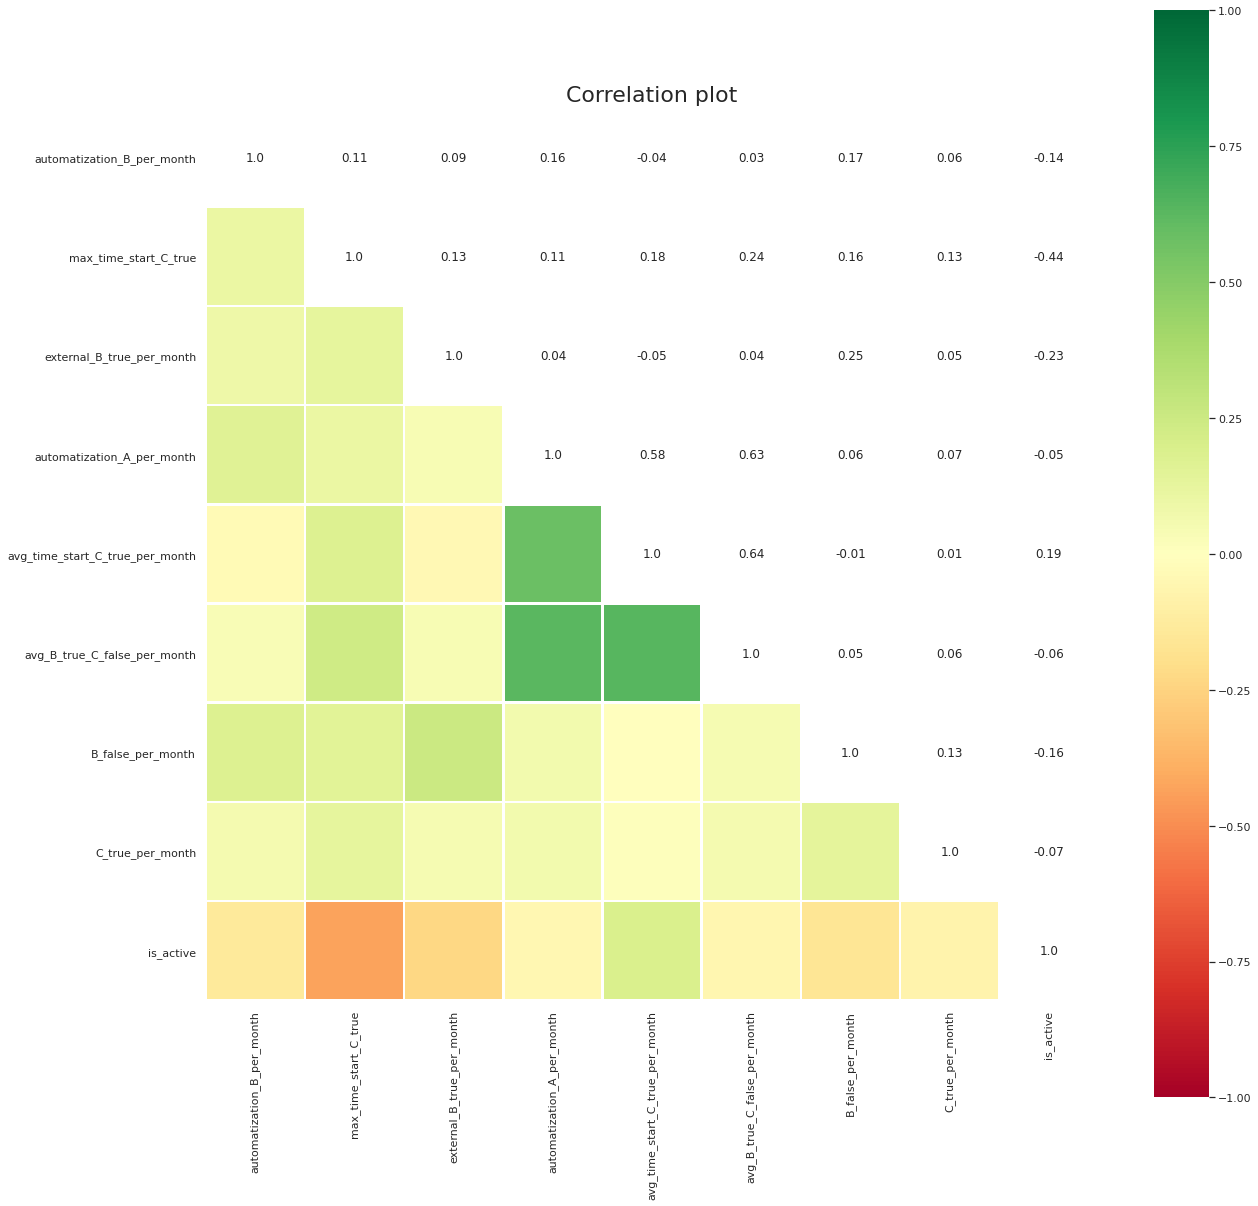

In [111]:
X_corr=df_contract[['automatization_B_per_month','max_time_start_C_true','external_B_true_per_month','automatization_A_per_month',
               'avg_time_start_C_true_per_month','avg_B_true_C_false_per_month','B_false_per_month','C_true_per_month','is_active']]
sns.set(style="white")
fig, ax = plt.subplots(1, figsize=(20, 20))
corr = X_corr.corr()
labels = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
labels = labels.round(2)
labels = labels.replace(np.nan, ' ', regex=True)

mask = np.triu(np.ones(corr.shape)).astype(np.bool)
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='RdYlGn',
    fmt='',
    square=True,
    linewidths=1.5).set_title("Correlation plot", fontsize=22)
mask = np.ones(corr.shape) - mask
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=ListedColormap(['white']),
    annot=labels,
    cbar=False,
    fmt='',
    linewidths=1.5)

Finally, the following variables are using by the final model:
- **automatization_B_per_month**: Percentage of cases that reached a B_True or B_False automatically from the A_True by means of a predefined external input. No manual work was involved.
-	**max_time_start_C_true**: maximun time measured in days that took a case to reach C_true from the start with the applied grouping operation. According to the correlation plot, When this measure increases the probability of churn increase.
-	**external_B_true_per_month**: number of cases introduced externally that are in state B_true per month. According to the correlation plot, When this measure increases the probability of churn increase.
-	**automatization_A_per_month**: Percentage of cases that reached a A_True or A_False automatically from the start by means of a predefined external input. No manual work was involved.
-	**avg_time_start_C_true_per_month**: average time measured in days that took a case to reach C_true from the start with the applied grouping operation.
-	**avg_B_true_C_false_per_month**: average time measured in days that took a case to reach C_false from the start with the applied grouping operation.
-	**B_false_per_month**: number of cases that are in state B_false.
- **C_true_per_month**:  number of cases that are in state C_True.

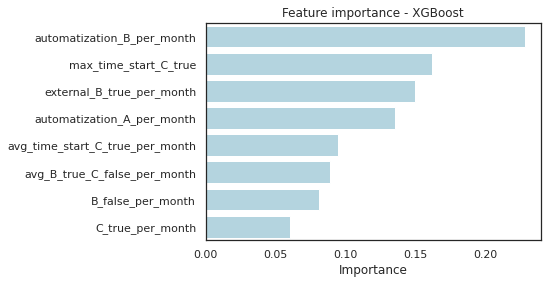

In [104]:
plot_data2=plot_data[0:8]
sns.barplot(y=plot_data2['feature'],x=plot_data2['v_importance'],orient='h', color='lightblue')
plt.xlabel('Importance');
plt.ylabel('');
plt.title('Feature importance - XGBoost');

In [108]:
new_variables=['automatization_B_per_month','max_time_start_C_true','external_B_true_per_month','automatization_A_per_month',
               'avg_time_start_C_true_per_month','avg_B_true_C_false_per_month','B_false_per_month','C_true_per_month']
X_new=df_contract[new_variables]

In [109]:
 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, random_state=0,test_size =0.2)
#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

In [110]:
model_xgb = xgb.XGBClassifier(n_jobs=-1)

xgb_cv2 = RandomizedSearchCV(model_xgb, params, n_iter=2000, verbose=True, cv=3)
xgb_cv2.fit(Xtrain, ytrain)
ypred = xgb_cv2.predict(Xtest)

yproba = xgb_cv2.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6000 out of 6000 | elapsed:  8.6min finished


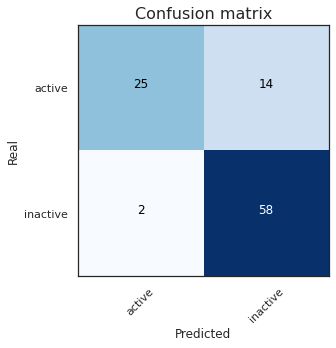

In [112]:
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# Gráfico
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['active','inactive'])

In [113]:
tn, fp, fn, tp = cnf_matrix.ravel()
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", round(acc_,3))
# Precision : 
pre_ = (tp) / (tp + fp)
print("Precision  : ", round(pre_,3))
# Recall : 
sens_ = tp / (tp + fn)
print("Recall  : ", round(sens_,3))
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", round(sp_,3))
print("F1_score: ", round(metrics.f1_score(ytest, ypred),3))
print("AUC_score: ", round(metrics.roc_auc_score(ytest, ypred),3))
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))

Accuracy  :  0.838
Precision  :  0.806
Recall  :  0.967
Specificity  :  0.641
F1_score:  0.879
AUC_score:  0.804
Log Loss:  0.377
